## Generate Wordclouds

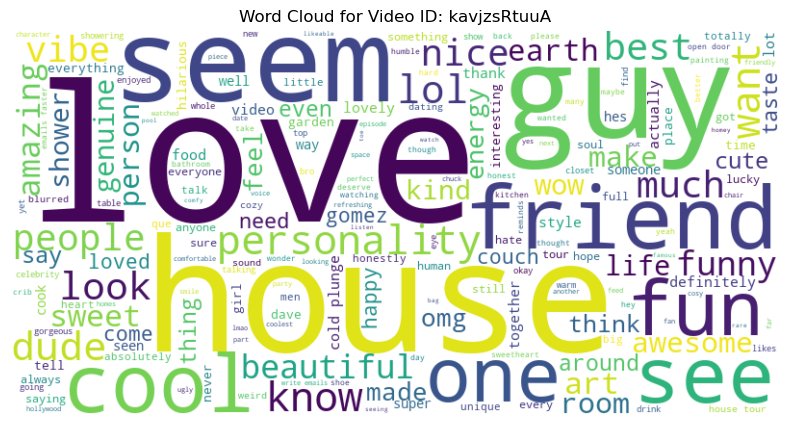

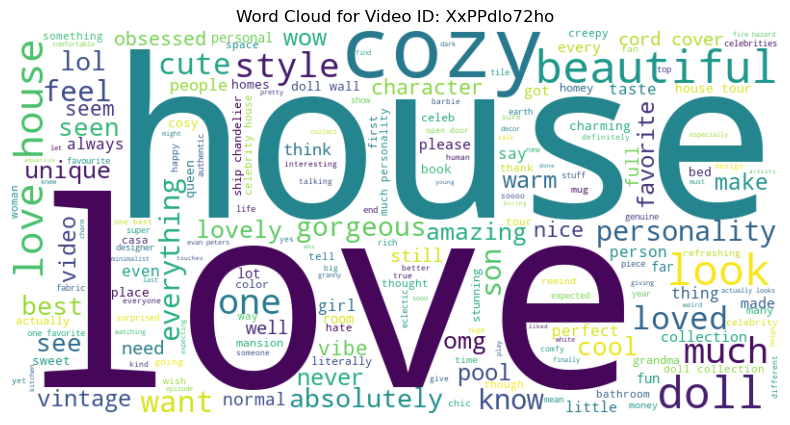

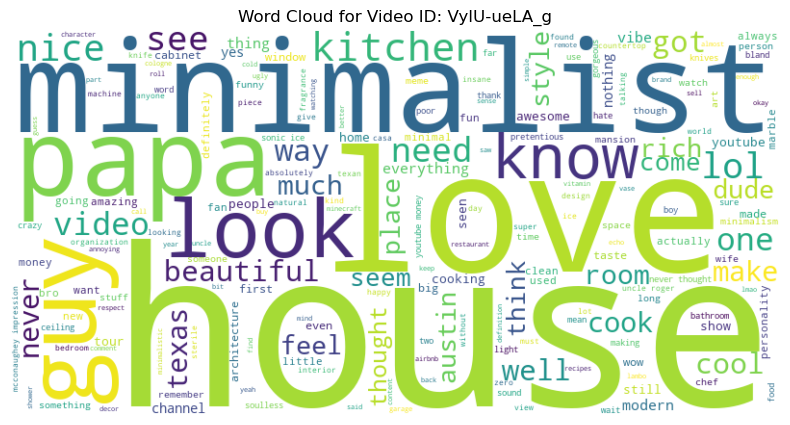

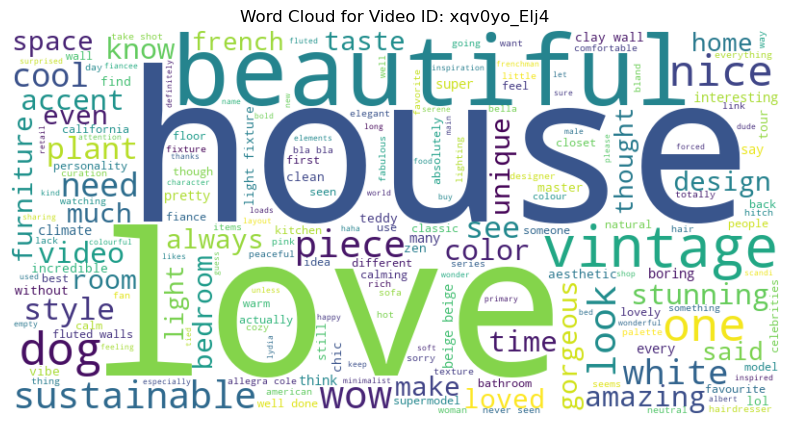

KeyboardInterrupt: 

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import ast

# Load the CSV file
df = pd.read_csv('cleaned_comments.csv')

# Get the first 10 unique video IDs
unique_video_ids = df['Video ID'].unique()[:10]

for video_id in unique_video_ids:
    # Filter rows by video ID
    filtered_df = df[df['Video ID'] == video_id]

    # Extract tokens and combine into a single list
    all_tokens = []
    for tokens_str in filtered_df['Tokens']:
        tokens_list = ast.literal_eval(tokens_str)
        all_tokens.extend(tokens_list)

    # Join all tokens into a single string
    text = ' '.join(all_tokens)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.title(f'Word Cloud for Video ID: {video_id}')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


## Merging Comment and Description Tokens
## Generating Topics using LDA
### Save topics.csv
Reference: 

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://radimrehurek.com/gensim/models/ldamodel.html#

In [1]:
import pandas as pd
from gensim import corpora, models

comments_df = pd.read_csv('cleaned_comments.csv')
descriptions_df = pd.read_csv('descriptions.csv')

# Merge dataframes by 'Video ID' column
merged_df = pd.merge(comments_df, descriptions_df, on='Video ID')

# Short list of personality showing keywords
personality_keywords = ['personality', 'friend', 'friendly', 'funny']

# List of unique Video IDs
video_ids = merged_df['Video ID'].unique()

topics_data = []

for video_id in video_ids:
    
    # Extract Tokens and remove personality_keywords
    # Convert 'Tokens' string representation of list to actual list
    filtered_comments = merged_df[
        (merged_df['Video ID'] == video_id) & 
        ~merged_df['Tokens'].str.contains('|'.join(personality_keywords))]['Tokens'].apply(eval).tolist()
    
    # Extract Main Description
    filtered_descriptions = merged_df[merged_df['Video ID'] == video_id]['Main Description'].tolist()
    
    # Convert descriptions to list of lists
    filtered_descriptions = [[description] for description in filtered_descriptions]

    # Combine comments and descriptions into a single list
    combined_text = [comment + description for comment, description in zip(filtered_comments, filtered_descriptions)]

    # Creates dictionary from combined data 
    # Eacg word get assigned a unique integer ID
    dictionary = corpora.Dictionary(combined_text)

    # Creates Corpus
    # Big list where each item represents a document, and each document is represented by its 'bag of words'
    corpus = [dictionary.doc2bow(text) for text in combined_text]

    # Train LDA Model
    num_topics = 10  
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    
    # Save topics to the empty DataFrame
    for topic in lda_model.print_topics():
        topics_data.append({'Video ID': video_id, 'Topic': topic})
        
    # Print topics 
    print(f"Topics for Video ID: {video_id}")
    for topic in lda_model.print_topics():
        print(topic)
        
# Convert list of topics to a DataFrame
topics_df = pd.DataFrame(topics_data)

topics_df.to_csv('topics.csv', index=False)


Topics for Video ID: kavjzsRtuuA
(0, '0.089*"[\'ad\', \'welcomed\', \'hit\', \'music\', \'producer\', \'tour\', \'home\', \'los\', \'built\', \'spacious\', \'home\', \'throw\', \'away\', \'recording\', \'despite\', \'proximity\', \'design\', \'brief\', \'help\', \'rachel\', \'leigh\', \'ward\', \'dana\', \'vitrano\', \'bonvivant\', \'interiors\', \'designer\', \'keefe\', \'butler\', \'studio\', \'resulting\', \'space\', \'eclectic\', \'playful\', \'plenty\', \'kick\', \'back\', \'relax\', \'family\', \'including\', \'superstar\', \'girlfriend\', \'selena\', \'red\', \'velvet\', \'movie\', \'theatre\', \'candy\', \'room\', \'dressing\', \'home\', \'full\', \'personality\', \'fun\', \'know\', \'house\', \'friend\', \'told\', \'love\', \'coming\', \'house\', \'feel\', \'like\', \'let\', \'go\', \'true\', \'exactly\', \'going\', \'shop\', \'pieces\', \'inspired\', \'la\', \'buy\', \'something\', \'retail\', \'earn\', \'affiliate\', \'see\', \'la\', \'home\', \'artwork\', \'courtesy\', \'ni

## Clean and Parse topics
### Save top_5_topics.csv

In [125]:
import pandas as pd
import ast

# Read the topics.csv file into a DataFrame
topics_df = pd.read_csv('topics.csv')

# Convert the 'Topic' column to string type
topics_df['Topic'] = topics_df['Topic'].astype(str)

# Function to clean and parse the topic strings
def clean_and_parse_topic(topic_content):
    # Remove leading and following parentheses, splits string after first comma, Keeps the second part
        topic_content = topic_content.strip("()")
        parts = topic_content.split(", ", 1)
        if len(parts) > 1:
            topic_content = parts[1]
        
        # Replace specific problematic characters
        cleaned_content = topic_content.replace('""', '').replace("'", "").replace('\\', '')
        
        # Extracts the description weight
        desc_weight = float(cleaned_content.split("*")[0])
        
        # Extracts the topics
        topics = []
        parts = cleaned_content.split(" + ")
        for part in parts:
            if '*' in part:
                _, topic = part.split('*', 1)
                topic = topic.strip()
                topics.append(topic)
        return desc_weight, topics

# Group by 'Video ID'
grouped = topics_df.groupby('Video ID')

# Function to extract top 5 topics based on weights
def get_top_5_topics(group):
    topics = []
    for _, row in group.iterrows():
        desc_weight, topic_info = clean_and_parse_topic(row['Topic'])
        if topic_info:
            topics.append((desc_weight, topic_info))
    # Sort topics based on description weights and select the top 5
    top_5_topics = sorted(topics, key=lambda x: x[0], reverse=True)[:5]
    return [(weight, topic) for weight, topic in top_5_topics]


# Apply the function to each group and sets new column names
result = grouped.apply(get_top_5_topics).reset_index()
result.columns = ['Video ID', 'Top 5 Topics']

# Write the result to a new CSV file
result.to_csv('top_5_topics.csv', index=False)


/var/folders/qv/dfs9xlmx52x51qbbcp3zlfj00000gn/T/ipykernel_90151/496021732.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped.apply(get_top_5_topics).reset_index()


## Clean Final Top 5 topics
### Save cleaned_top_5_topics.csv
Reference:

https://www.analyticsvidhya.com/blog/2021/08/python-tutorial-working-with-csv-file-for-data-science/

In [33]:
import csv
import ast

# Open input and output files
with open('top_5_topics.csv', 'r', newline='', encoding='utf-8') as input_file, \
     open('cleaned_top_5_topics.csv', 'w', newline='', encoding='utf-8') as output_file:
   
    reader = csv.reader(input_file)
    writer = csv.writer(output_file)

    writer.writerow(['Video ID', 'Weight', 'Topics']) # Header

    next(reader) # Skip header

    # Iterate over each row in the input file
    for row in reader:
        video_id = row[0]  # Extract video ID
        topics = eval(row[1])  # Convert string representation of topics to a list

        # Iterate over each topic in the list
        for weight, topic_list in topics:
            # Filter out topics that start or end with square brackets
            topic_list = [topic for topic in topic_list if not topic.startswith('[') and not topic.endswith(']')]
            topic_string = ', '.join(topic_list)  # Convert topic list to a string
            writer.writerow([video_id, weight, topic_string])

Cleaning complete. Output saved to cleaned_top_5_topics.csv


## Further processing 

In [28]:
import pandas as pd
import ast

# Read the CSV file
df = pd.read_csv("cleaned_top_5_topics.csv")

def process_topics(topics): 
    # Remove the triple quotes and split the string into two parts
    parts = topics.replace('"""', '').split('", "', 1)
    
    # Check if there are two parts
    if len(parts) == 2:        

        return parts[1]

# Apply to the Topics column
df['Topics'] = df['Topics'].apply(process_topics)


df.to_csv("cleaned_top_5_topics.csv", index=False)


## Counting topic words and final dataframe
### Save sd_topics

In [26]:

from collections import defaultdict, Counter

df = pd.read_csv("cleaned_top_5_topics.csv")

# Store topics for each video
topics_dict = defaultdict(set)

# Counts frequency of each word
word_counter = Counter()

remove_words = ["love", "loved", "lovely", "house", "home", "like", "gorgeous", "amazing", "beautiful", "ever", 
                "lol", "omg", "nice", "like", "cool", "best", "looks", "would", "one", "much", "room",
                "look", "wow", "see", "good", "know", "stunning", "people", "want", "style", "seen", "place", 
                "video", "taste", "cute", "everything", "well", "absolutely", "get", "space", "anyone", "tour",
                "apartment", "money", "design", "vibe", "could", "seems", "way", "favorite", "happy", "rich", "thank",
                "two", "still", "need", "every", "feel", "show", "many", "got", "damn", "time", "please", "thought", "blurred",
                "homes", "voice", "someone", "yes", "actually", "done", "god", "life", "going", "ariel", "pretty", "laugh", "person",
                "together", "though", "always", "thing", "vibes", "also", "day", "else", "episode", "say", "que", "think", "melo", "little",
                "loves", "awesome", "never", "rooms", "proud", "riverdale", "job", "queen", "watch", "sharing", "thanks", "lady", "married", 
                "right", "baby", "houses"]

# Iteration over each row in the dataframe
for index, row in df.iterrows():
    video_id, weight, topics = row['Video ID'], row['Weight'], row['Topics']
    # Remove extra quotation marks
    topics = topics.replace('"', '')
    # Splits topics into individual words
    topics = topics.split(", ")
    
    word_counter.update(topics)
    
    topics = [topic for topic in topics if topic not in remove_words]
    topics_dict[video_id].update(topics)
    
sd_topics = pd.DataFrame(columns=['Video ID', 'Topics'])

# Print the results
for video_id, topics in topics_dict.items():
    print(f"{video_id}: {', '.join(topics)}")
    # Add results to new dataframe
    new_row = pd.DataFrame({'Video ID': [video_id], 'Topics': [', '.join(topics)]})
    sd_topics = pd.concat([sd_topics, new_row], ignore_index=True)
        
sd_topics.to_csv('sd_topics.csv', index=False)

print("\nMost common words:")
for word, count in word_counter.most_common(150):  
    print(f"{word}: {count}")


-TeeIEh2IE8: remember, body, keep, cold, gallery, second, art, trophies, times, trophy, museum, chair, trash, elmo, door, nepal, unique, magazine
-zkOLKMiX9c: pepper, body, art, woman, old, white
0K9eZCW-lvc: body, sweet, kitchen, tate, cozy, dress, something
0_BEwbnmRZ4: panic, man, humor, jazzy, monotone, hilarious, sounds, leave, spanish, guy
5WH-PSs9hI8: mama, fracking, joy, drag, color, black, disco, white, closet
5vNoHwgoIjw: mcguire, sons, dress, lizzie, girl, samsung, chickens, fish, kids, chicken, coop
5zvsAwsEwPg: joy, couple, wife, story, sweet
7R2RyqU4hjI: needs, accent, couple, castle, irish, catherine, haunted, garden, pot, mcnulty, family, ancestors, title, wonderful
7Z76MiQv0zg: magnolia, attic, arwen, asmr, soothing, soul, sword, sweet, lotr, woman, display, tree
7cGmj0AR3z8: handsome, quality, statue, casa, colombian, creepy, bedroom, hot, jersey, coffee, colombia, neymar, guy
80z6drP0NY8: decor, furniture, first, mind, miss, come, older, man, player, jordan, nba, fut